<style>
/* - Page & typography - */
body {
  max-width: 900px;
  margin: auto;
  font-family: Georgia, "Times New Roman", serif;
  line-height: 1.65;
  font-size: 16px;
  background: #ffffff;
  color: #111;
}

/* Paragraphs */
p {
  margin: 0.85em 0;
  text-align: justify;
  hyphens: auto;
}

/* - Headings (full hierarchy) - */
h1 {
  font-size: 2.3em;
  margin-top: 2.8em;
  margin-bottom: 0.6em;
  border-bottom: 2px solid #ddd;
  padding-bottom: 0.3em;
}

h2 {
  font-size: 1.65em;
  margin-top: 2.3em;
  margin-bottom: 0.5em;
}

h3 {
  font-size: 1.35em;
  margin-top: 1.9em;
  margin-bottom: 0.4em;
  color: #333;
}

h4 {
  font-size: 1.15em;
  margin-top: 1.6em;
  margin-bottom: 0.3em;
  font-weight: bold;
  color: #444;
}

h5 {
  font-size: 1.05em;
  margin-top: 1.3em;
  margin-bottom: 0.2em;
  font-weight: bold;
  color: #555;
}

h6 {
  font-size: 1em;
  margin-top: 1.1em;
  font-style: italic;
  color: #666;
}

/* - Screenshots - */
img {
  display: block;
  margin: 1.6em auto;
  max-width: 85%;
  max-height: 500px;
  height: auto;
  border-radius: 6px;
  border: 1px solid #ddd;
  box-shadow: 0 2px 6px rgba(0,0,0,0.12);
}

/* Caption-style text after screenshots */
img + p {
  text-align: center;
  font-size: 0.9em;
  color: #555;
  margin-top: -0.9em;
}

/* - Code blocks - */
pre, code {
  font-family: "DejaVu Sans Mono", monospace;
  font-size: 0.95em;
}

pre {
  background: #f6f6f6;
  border-left: 4px solid #bbb;
  padding: 0.9em;
  overflow-x: auto;
  border-radius: 4px;
}

/* - Lists - */
ul, ol {
  margin-left: 1.4em;
}

li {
  margin: 0.4em 0;
}

/* - Page-break safety (printing) - */
h1, h2, h3, h4, h5, h6,
pre, blockquote, img {
  page-break-inside: avoid;
}

/* - Links - */
a {
  color: #0645ad;
  text-decoration: none;
}

a:hover {
  text-decoration: underline;
}

/* - Print refinements - */
@media print {
  body {
    font-size: 15px;
    color: black;
  }

  a {
    color: black;
    text-decoration: none;
  }
}
</style>


# **Chapter 7: Synchronization Examples - Section 7.1.1 The Bounded-Buffer Problem**

## **Chapter Introduction & Objectives**
This chapter applies the **synchronization tools** you learned in Chapter 6 (like mutex locks, semaphores, and monitors) to solve real, classic problems in operating systems.

**Remember from Chapter 6:** The **critical-section problem** is about preventing **race conditions** when multiple processes/threads access shared data. You studied solutions ranging from low-level **hardware instructions** (like compare-and-swap) to high-level **software tools** (mutex, semaphore, monitor). You also learned about **liveness hazards** like deadlock.

**Chapter 7 Objectives:**
1.  Explain three classic synchronization problems: **Bounded-Buffer**, **Readers-Writers**, and **Dining-Philosophers**.
2.  Describe how real OSes (Linux & Windows) handle synchronization.
3.  Show how to use **POSIX** and **Java APIs** for synchronization.
4.  Enable you to design your own solutions using these APIs.



## **7.1 Classic Problems of Synchronization**
This section presents famous problems that act as a standard test for any new synchronization technique. The solutions here use **semaphores** (the traditional teaching method), but in practice, you could often use **mutex locks** instead of binary semaphores.



### **7.1.1 The Bounded-Buffer Problem**
**What is this problem?** It's the classic **Producer-Consumer** problem, first introduced in Chapter 6.1. A producer process creates data items, and a consumer process uses them. They share a **fixed-size buffer** (a queue of `n` slots).

**Why is it important?** It's a perfect model for any scenario where data is passed from one executing entity to another with limited temporary storage (e.g., a print spooler, data pipes, or network packet buffers).

#### **Shared Data Structures**
The producer and consumer share these synchronization variables:
```c
int n;                      // Total number of buffers in the pool
semaphore mutex = 1;        // Binary semaphore (acts like a mutex lock). Ensures mutual exclusion for accessing the buffer pool itself. Initialized to 1 (unlocked).
semaphore empty = n;        // Counting semaphore. Tracks the number of EMPTY buffers. Initially, all `n` buffers are empty.
semaphore full = 0;         // Counting semaphore. Tracks the number of FULL buffers. Initially, there are zero full buffers.
```
*   **The Buffer Pool:** Think of it as an array of `n` slots. The `mutex` protects the actual insert/remove operations on this array.
*   **The Role of `empty` and `full`:** These semaphores handle the **synchronization condition**. The producer must wait if there are no empty slots (`empty == 0`). The consumer must wait if there are no full slots (`full == 0`).

#### **The Producer Process (Figure 7.1)**
```c
while (true) {
    ... // Produce an item (this takes time and is done OUTSIDE the critical section)
    wait(empty);  // DECREMENT the 'empty' count. WAIT here if empty == 0 (no free buffers).
    wait(mutex);  // ENTER critical section. Acquire lock on the buffer pool.
    ... // Add the produced item to the buffer (this is the actual critical section)
    signal(mutex); // EXIT critical section. Release the buffer pool lock.
    signal(full);  // INCREMENT the 'full' count. Signals consumer that a buffer is now ready.
}
```

**Step-by-step logic for the Producer:**
1.  **Produce Item:** Creates data. This is outside the critical section for efficiency.
2.  **`wait(empty);`**: This is **crucial**. The producer first checks if there's space. If `empty > 0`, it decrements `empty` and proceeds. If `empty == 0`, the buffer is full, and the producer **blocks here**, waiting for a consumer to free a slot.
3.  **`wait(mutex);`**: Now it safely acquires the lock to *manipulate the shared buffer* (the actual array/index).
4.  **Add to Buffer:** Performs the actual insert operation.
5.  **`signal(mutex);`**: Releases the lock on the buffer.
6.  **`signal(full);`**: Increments the `full` semaphore. This *signals* any waiting consumer that there is now at least one item to consume.

#### **The Consumer Process (Figure 7.2)**
*(The structure is symmetrical but opposite.)*
```c
while (true) {
    wait(full);   // DECREMENT the 'full' count. WAIT here if full == 0 (nothing to consume).
    wait(mutex);  // ENTER critical section. Acquire lock on the buffer pool.
    ... // Remove an item from the buffer (critical section)
    signal(mutex); // EXIT critical section.
    signal(empty); // INCREMENT the 'empty' count. Signals producer that a buffer is now free.
    ... // Consume the item (outside critical section)
}
```

**Step-by-step logic for the Consumer:**
1.  **`wait(full);`**: Checks if there's anything to consume. If `full > 0`, it decrements `full` and proceeds. If `full == 0`, the buffer is empty, and the consumer **blocks**.
2.  **`wait(mutex);`**: Acquires the lock to manipulate the buffer.
3.  **Remove from Buffer:** Takes an item from the buffer.
4.  **`signal(mutex);`**: Releases the lock.
5.  **`signal(empty);`**: Increments the `empty` semaphore. This *signals* any waiting producer that there is now at least one free slot.
6.  **Consume Item:** Uses the data. Done outside the critical section.

#### **Why This Solution Works (Key Insights)**
*   **Symmetry:** The producer "produces" full buffers for the consumer. The consumer "produces" empty buffers for the producer.
*   **Order of `wait()` Calls is SAFE:** Notice both processes acquire the **condition semaphore** (`empty` or `full`) *before* the **mutual exclusion semaphore** (`mutex`). This prevents **deadlock**. Imagine if they took `mutex` first: A producer could lock the buffer and then find it full, but it would be holding the lock while waiting, preventing any consumer from running to empty a buffer. This is a classic deadlock scenario. The presented order avoids it.
*   **Separation of Concerns:** `mutex` handles **mutual exclusion** (short, fast operations). `empty`/`full` handle **synchronization** (waiting for a condition). This is a clean and efficient pattern.

**In Modern Practice:** The `mutex` semaphore (binary) would typically be implemented as a simpler **mutex lock**. The `empty` and `full` semaphores (counting) are essential **condition variables**.

### **7.1.2 The Readers-Writers Problem**

#### **Problem Definition and Scenario**
Imagine a shared **database** accessed by multiple concurrent processes. Processes are of two types:
*   **Readers:** Processes that only **read** the database. They examine data but do not modify it.
*   **Writers:** Processes that both **read and update** (write to) the database. They change the data.

**The Core Conflict:**
1.  **Multiple Readers:** If **two or more readers** access the database simultaneously, it's **perfectly safe**. No data is being changed, so they will all see a consistent state.
2.  **Writer with Any Other Process:** If a **writer** accesses the database simultaneously with **any other process** (another writer *or* a reader), **serious problems (chaos) can occur.**
    *   A reader might see partially updated, inconsistent data.
    *   Two writers might overwrite each other's changes.

**The Synchronization Requirement:** **Writers must have exclusive access** to the shared database. When a writer is active, no other readers or writers can be active. This is the essence of the **readers-writers problem**.

#### **Variations and Priority Policies**
The problem has tricky variations based on **priority**, which lead to different behaviors and potential **starvation**.

1.  **The First Readers-Writers Problem:**
    *   **Rule:** *No reader should be kept waiting unless a writer has already obtained permission to use the shared object.*
    *   **Priority:** **Readers have priority.**
    *   **How it works:** If a reader arrives and a writer is *merely waiting* (but hasn't started), the reader can jump ahead and start reading. Furthermore, if one reader is active, all other arriving readers can join in immediately.
    *   **Consequence:** A steady stream of readers can cause a waiting writer to **starve** (wait forever). This is known as **writer starvation**.

2.  **The Second Readers-Writers Problem:**
    *   **Rule:** *Once a writer is ready, that writer performs its write as soon as possible.*
    *   **Priority:** **Writers have priority.**
    *   **How it works:** If a writer is waiting, no *new* readers are allowed to start reading. The system waits for the current readers to finish, then lets the writer go. New readers must wait until no writers are waiting.
    *   **Consequence:** A steady stream of writers can cause waiting readers to **starve**. This is **reader starvation**.

The textbook notes that **both of these simple solutions can lead to starvation**. More complex, **starvation-free** solutions exist (and are referenced in the bibliography). The solution presented next is for the **First Readers-Writers Problem** (reader-priority).

#### **Structure of the Consumer Process (Go to Figure 7.2)**
*(This figure is from the previous Bounded-Buffer section and is shown again here for context. Let's recap it clearly.)*

**The Consumer Process Code:**
```c
while (true) {
    wait(full);        // Step 1: Wait until there's at least one full buffer (blocks if full == 0).
    wait(mutex);       // Step 2: Acquire lock to access the buffer pool.
    ... // Critical Section: Remove an item from the buffer.
    signal(mutex);     // Step 3: Release the buffer pool lock.
    signal(empty);     // Step 4: Signal that an empty buffer slot has been created.
    ... // Consume the item (outside the critical section, so it doesn't block others).
}
```

**Important Symmetry:** Compare this with the Producer in Figure 7.1. The Consumer is its mirror image: it waits on `full`, signals `empty`, and its internal critical section is a *remove* operation instead of an *add*.

#### **Key Takeaway for Readers-Writers**
The Readers-Writers problem is more complex than the Bounded-Buffer because it involves **two classes of processes** with different synchronization rules:
*   **Mutual Exclusion for Writers:** Must be absolute (like the mutex in the buffer problem).
*   **Concurrent Access for Readers:** Must be allowed, but only in the *absence* of a writer.

The upcoming solution will need **shared variables** to *track the number of active readers* so the first reader locks out writers and the last reader lets them in.


#### **Solution to the First Readers-Writers Problem (Reader-Priority)**

##### **Shared Data Structures**
The solution uses the following shared variables:
```c
semaphore rw_mutex = 1;  // Binary semaphore. Main lock for writers AND the first/last reader.
semaphore mutex = 1;     // Binary semaphore. Protects the shared integer 'read_count' from race conditions.
int read_count = 0;      // Integer counter. Tracks the number of currently active readers.
```

**Purpose of Each Variable:**
*   **`rw_mutex` (The "Database Lock"):** This is the fundamental semaphore that ensures **writers have exclusive access**. A writer must hold this to enter its critical section. It also serves a special purpose for readers.
*   **`mutex` (The "Counter Lock"):** This semaphore provides **mutual exclusion for updating `read_count`**. Since multiple readers may try to increment/decrement `read_count` simultaneously, we must protect it to avoid a race condition on the counter itself.
*   **`read_count`:** The key to allowing concurrent reading. It answers the question: "Are we switching between a state with *zero readers* and a state with *some readers*?"

##### **The Writer Process (Go to Figure 7.3)**
The writer's logic is straightforward, similar to a standard mutual exclusion critical section.
```c
while (true) {
    wait(rw_mutex);   // Acquire exclusive lock on the database. Blocks if held by anyone (writer or first reader).
    ... // Critical Section: Writing is performed here. Exclusive access guaranteed.
    signal(rw_mutex); // Release the lock on the database.
}
```
*   **A writer only cares about `rw_mutex`.** If `rw_mutex` is available (value 1), the writer grabs it and proceeds, locking out all other writers *and* any new readers. If `rw_mutex` is held (by another writer or by the *first* active reader), the writer blocks on this semaphore.

##### **The Reader Process (Go to Figure 7.4)**
The reader's logic is more complex because it must coordinate with other readers.
```c
while (true) {
    // ENTRY SECTION
    wait(mutex);               // Step 1: Lock the read_count variable.
    read_count++;              // Step 2: Announce I'm becoming an active reader.
    if (read_count == 1) {     // Step 3: AM I THE *FIRST* READER?
        wait(rw_mutex);        // Step 3a: If yes, I must lock out writers by acquiring rw_mutex.
    }
    signal(mutex);             // Step 4: Release the lock on read_count. Other readers can now update it.

    ... // Critical Section: Reading is performed here. Multiple readers can be here concurrently.

    // EXIT SECTION
    wait(mutex);               // Step 5: Lock the read_count variable again.
    read_count--;              // Step 6: Announce I'm leaving.
    if (read_count == 0) {     // Step 7: AM I THE *LAST* READER LEAVING?
        signal(rw_mutex);      // Step 7a: If yes, release the rw_mutex so a waiting writer can proceed.
    }
    signal(mutex);             // Step 8: Release the lock on read_count.
}
```

##### **How This Solution Works (Step-by-Step Logic)**

**Scenario 1: A Reader Arrives When No One is Active**
1.  Reader acquires `mutex` (easy).
2.  `read_count` becomes 1.
3.  Since `read_count == 1`, it executes `wait(rw_mutex)`. This succeeds, locking `rw_mutex`.
4.  Releases `mutex`.
5.  **Now:** The reader is reading. `rw_mutex` is held (by this first reader), so any arriving writer will block on `wait(rw_mutex)`.

**Scenario 2: Another Reader Arrives While One is Reading**
1.  Second reader acquires `mutex`.
2.  Increments `read_count` to 2.
3.  `read_count != 1`, so it **does NOT** call `wait(rw_mutex)`.
4.  Releases `mutex`.
5.  **Now:** Both readers are reading concurrently. The second reader did **not** wait on `rw_mutex` because it's already held (for writers).

**Scenario 3: A Writer Arrives While Readers are Active**
1.  Writer calls `wait(rw_mutex)`. Since `rw_mutex` is held by the *first reader*, the writer **blocks here**.
2.  **This is the key to reader priority:** New readers can still jump in! A reader arriving now will see `read_count > 0`, skip the `wait(rw_mutex)`, and start reading immediately, even with a writer waiting.

**Scenario 4: The Last Reader Leaves**
1.  When the final reader executes its exit section, `read_count` goes from 1 to 0.
2.  Because `read_count == 0`, it calls `signal(rw_mutex)`.
3.  This **wakes up a single process** waiting on `rw_mutex`. This could be a writer or, if no writer is waiting, the next reader that might be stuck at `wait(rw_mutex)` (this only happens if a writer was waiting in between reader groups). **The scheduler decides which one proceeds.**

##### **Important Observations from the Text**
*   **Queuing Behavior:** If a writer is in its critical section, and `n` readers are waiting:
    *   **1 reader** is queued on `rw_mutex` (the "first" reader of the group, blocked because the writer holds it).
    *   **`n-1` readers** are queued on `mutex` (they are stuck trying to increment `read_count`, blocked behind the first reader who is holding `mutex` while it waits on `rw_mutex`). *(Go to Figure 7.4 to trace this: a reader holds `mutex` when it checks `if (read_count == 1)` and calls `wait(rw_mutex)`. It does not release `mutex` until after that possible wait.)*
*   **Scheduler Decision:** The `signal(rw_mutex)` call doesn't specify who wakes up. If both readers and writers are waiting, the OS scheduler chooses. This inherent non-determinism can contribute to starvation in this simple solution.

##### **Generalization: Reader-Writer Locks**
The textbook notes that this problem is so common that many systems provide a **reader-writer lock** as a direct synchronization primitive.

*   **How it works:** A process requests the lock in a specific **mode**: **read mode** or **write mode**.
*   **Rules:**
    *   Multiple processes can hold a **read-mode** lock concurrently.
    *   Only one process can hold a **write-mode** lock, and it must have exclusive access (no other readers or writers).

*   **When to Use Reader-Writer Locks:**
    1.  When you can clearly identify which threads are **readers-only** and which are **writers**.
    2.  When your application has **many more reads than writes**. The performance overhead of managing the reader-writer lock is worth it because the **increased concurrency (multiple readers)** provides a significant speedup over a simple mutex that would allow only one reader at a time.


### **7.1.3 The Dining-Philosophers Problem**

#### **Problem Scenario (Go to Figure 7.5)**

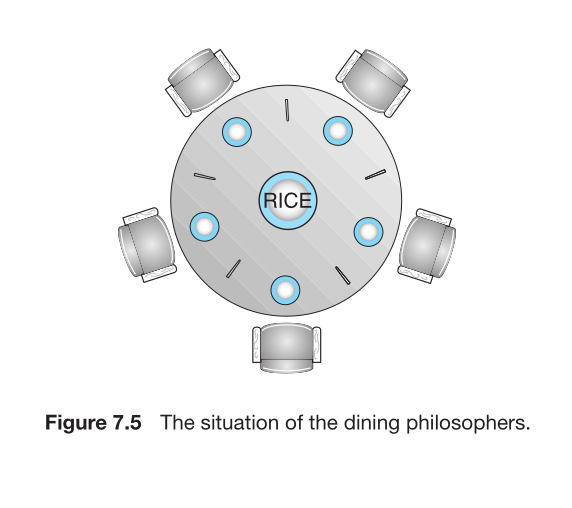


Imagine **five philosophers** sitting at a **circular table**. Each philosopher's life alternates between **thinking** and **eating**.
*   In front of each philosopher is a plate.
*   In the center of the table is a **bowl of rice** (the shared data/resource).
*   Between each pair of adjacent philosophers lies a **single chopstick**. This means there are five chopsticks total.
*   **Rule:** To eat, a philosopher needs **two chopsticks**—the one to their **left** and the one to their **right**. They can only pick up one chopstick at a time, and cannot take a chopstick from a neighbor's hand.

#### **Why This Problem is Important**
The textbook clarifies: This is a classic problem **not** because philosophers are important, but because it perfectly models a large class of real-world concurrency problems. It represents the challenge of **allocating multiple resources among multiple processes** while avoiding both **deadlock** and **starvation**.

**Mapping to Computing:**
*   **Philosopher = Process/Thread**
*   **Chopstick = Shared Resource (like a tape drive, I/O port, or a lock)**
*   **Eating = Executing in a critical section that requires two resources.**




#### **7.1.3.1 Semaphore Solution**

##### **The Flawed Implementation**
The textbook presents a direct but **flawed** semaphore-based implementation.

**Shared Data:**
```c
semaphore chopstick[5]; // Each semaphore is initialized to 1.
```
Each chopstick is represented by a binary semaphore. `wait()` acquires it; `signal()` releases it.

**Structure of Philosopher `i` (Recap from Figure 7.6):**
```c
while (true) {
    wait(chopstick[i]);               // 1. Pick up left chopstick
    wait(chopstick[(i + 1) % 5]);     // 2. Pick up right chopstick
    ... // Eat (Critical Section)
    signal(chopstick[i]);             // 3. Put down left
    signal(chopstick[(i + 1) % 5]);   // 4. Put down right
    ... // Think
}
```

##### **Analysis of the Flawed Solution**
*   **What it DOES guarantee:** **Mutual exclusion** on each chopstick. No two neighboring philosophers can be eating at the same time because they share a chopstick.
*   **What it DOES NOT prevent: DEADLOCK.**
*   **The Deadlock Scenario (Repeated for Clarity):** If all five philosophers execute `wait(chopstick[i])` simultaneously before any can get to their second `wait()`:
    *   Philosopher 0 holds chopstick 0.
    *   Philosopher 1 holds chopstick 1.
    *   Philosopher 2 holds chopstick 2.
    *   Philosopher 3 holds chopstick 3.
    *   Philosopher 4 holds chopstick 4.
    *   **Now:** `chopstick[]` array values are all 0 (held). Each philosopher is now **blocked forever** on `wait(chopstick[(i+1) % 5])` because that chopstick is held by their neighbor. **Circular wait** is established. The system halts.


##### **The Core Challenge**
The Dining-Philosophers problem forces us to design a protocol (synchronization scheme) that satisfies:
1.  **Mutual Exclusion:** A chopstick can be held by only one philosopher at a time.
2.  **Hold and Wait:** A philosopher holds one chopstick while waiting for another. (We may need to break this condition to prevent deadlock).
3.  **No Preemption:** Chopsticks cannot be forcibly taken from a philosopher. (This condition is usually kept).
4.  **Circular Wait:** The scenario described above. (This is the condition we must explicitly break).


We also need to guard against **starvation** (a philosopher might never get to eat even though others do).

##### **Possible Remedies to Prevent Deadlock**
The textbook suggests several strategies. All aim to **break at least one of the four necessary conditions for deadlock** (Mutual Exclusion, Hold and Wait, No Preemption, Circular Wait).

##### **Remedy 1: Limit Concurrent Philosophers**
**Allow at most four philosophers to be sitting simultaneously at the table.**
*   **How:** Use an additional **counting semaphore** `table` initialized to 4.
*   **Implementation:** A philosopher must call `wait(table)` *before* attempting to pick up any chopsticks, and `signal(table)` after putting them down.
*   **Why it Works (Breaks Circular Wait):** With only 4 actors for 5 resources (chopsticks), the **Pigeonhole Principle** guarantees at least one philosopher will be able to acquire two chopsticks. There will always be at least one free chopstick between two seated philosophers, breaking the inevitable circle of five holds-and-waits.

##### **Remedy 2: Acquire Both Chopsticks Atomically**
**Allow a philosopher to pick up her chopsticks only if both are available.**
*   **How:** Use an additional **binary semaphore or mutex lock** (`mutex`) to make the check-and-acquire of *both* chopsticks a **single, atomic (indivisible) operation**.
*   **Implementation:** The philosopher first `wait(mutex)`, then **check** if both her left and right chopsticks are free. If yes, she picks up both (setting their semaphores to 0), then `signal(mutex)`. If not, she releases `mutex` and retries or waits.
*   **Why it Works (Breaks Hold and Wait):** A philosopher does **not** hold any resource while waiting. They are either idle or hold *both* resources. This eliminates the "hold one, wait for another" scenario.

##### **Remedy 3: Asymmetric Acquisition Order**
**Use an asymmetric solution.**
*   **Rule:** Odd-numbered philosophers pick up their **left chopstick first**, then their right. Even-numbered philosophers pick up their **right chopstick first**, then their left.
*   **Why it Works (Breaks Circular Wait):** This disrupts the uniform, clockwise circular waiting pattern. Philosopher 0 (even) grabs chopstick 1 (right), while Philosopher 1 (odd) grabs chopstick 1 (left). They now **contend for the same first resource** (chopstick 1). One will get it, the other will block, preventing the formation of a complete, unbroken circle of holds-and-waits around the table.



##### **Crucial Distinction: Deadlock vs. Starvation**
The textbook makes a **vitally important final point** in this section:
> "any satisfactory solution ... must guard against the possibility ... of starvation. A deadlock-free solution does not necessarily eliminate the possibility of starvation."

*   **Deadlock:** A **global system standstill** where *no* philosopher can make progress. It's usually caused by a structural flaw in the protocol (like the circular wait).
*   **Starvation (Livelock/Indefinite Postponement):** A **local, individual problem** where one or more philosophers may be *indefinitely denied* the chance to eat, even though others are eating and the system as a whole is making progress. This can happen due to scheduling policies or timing.
    *   **Example:** In the asymmetric solution, if philosophers 1 and 2 are very fast, they might always grab chopsticks just before philosopher 0 can, causing philosopher 0 to repeatedly miss out.

**Conclusion:** A correct solution must be both **deadlock-free** and strive to be **starvation-free**. The remedies above address deadlock; preventing starvation often requires additional fairness mechanisms (like FIFO queues on semaphores).


#### **7.1.3.2 Monitor Solution**

##### **Introduction to the Monitor Approach**
This section presents a **deadlock-free solution** using a **monitor**, a high-level synchronization construct you learned in Chapter 6. Recall that a monitor is like a class where all data is private, and only one thread can be active inside the monitor's methods at a time, providing automatic mutual exclusion.

The core idea of this solution is **Remedy #2 from the previous section**: a philosopher picks up chopsticks **only if both are available**, and this check is performed **atomically** inside the monitor.

##### **Monitor Data Structures (Go to Figure 7.7)**

The `DiningPhilosophers` monitor encapsulates the following shared data:

1.  **`state[5]`:** An array tracking each philosopher's status. Each element can be one of three constants:
    *   `THINKING`: Philosopher is not trying to eat.
    *   `HUNGRY`: Philosopher wants to eat (has called `pickup()`), but doesn't have both chopsticks yet.
    *   `EATING`: Philosopher has both chopsticks and is eating.
2.  **`self[5]`:** An array of **condition variables**. `self[i]` is used to **suspend** philosopher `i` if she is hungry but cannot eat immediately (because a neighbor is eating). This is where a philosopher waits.

##### **The Monitor Operations Explained**

**Key Helper Function: `test(int i)`**
This function checks if philosopher `i` can start eating.
```c
void test(int i) {
    if ( (state[(i + 4) % 5] != EATING) &&  // Left neighbor is NOT eating
         (state[i] == HUNGRY) &&            // I am HUNGRY
         (state[(i + 1) % 5] != EATING) ) { // Right neighbor is NOT eating
        state[i] = EATING;                 // Change my state to EATING
        self[i].signal();                  // Wake me up if I was waiting
    }
}
```
*   **Atomic Check:** Because this runs inside the monitor, the check of **both neighbors' states** is atomic—no interleaving can occur.
*   **Why `(i+4) % 5`?** This is the index of the **left neighbor** (in a circle of 5, moving one step counter-clockwise).
*   **The `signal()`:** It only has an effect if philosopher `i` is actually waiting on `self[i]`. If she's not waiting (the transition from HUNGRY to EATING happened immediately in `pickup()`), the signal is ignored.

**Main Operation 1: `pickup(int i)`**
This is called by a philosopher when she gets hungry.
```c
void pickup(int i) {
    state[i] = HUNGRY;  // Step 1: Declare intent to eat.
    test(i);            // Step 2: Check if I can eat right now.
    if (state[i] != EATING) { // Step 3: Did the test() succeed?
        self[i].wait(); // Step 3a: If not, wait on my condition variable.
    }
}
```
**Logic Flow:**
1.  Philosopher `i` sets her state to `HUNGRY`.
2.  Calls `test(i)`. If both neighbors are not eating, `test(i)` will:
    *   Set `state[i] = EATING`
    *   Call `self[i].signal()` (which does nothing now, as she's not waiting).
3.  The philosopher then checks her own state. If `test(i)` succeeded, `state[i]` is already `EATING`, so she **skips the wait** and returns from `pickup()` immediately to start eating.
4.  If `test(i)` failed (a neighbor is eating), her state remains `HUNGRY`. She then executes `self[i].wait()`. This **releases the monitor lock** and suspends her thread, queuing it on condition variable `self[i]`.

**Main Operation 2: `putdown(int i)`**
This is called by a philosopher when she finishes eating.
```c
void putdown(int i) {
    state[i] = THINKING;       // Step 1: I'm done eating.
    test((i + 4) % 5);         // Step 2: See if my LEFT neighbor can now eat.
    test((i + 1) % 5);         // Step 3: See if my RIGHT neighbor can now eat.
}
```
**Logic Flow:**
1.  Philosopher sets her state back to `THINKING`.
2.  She **tests her two neighbors** (left, then right). This is crucial. When a philosopher puts down chopsticks, she might be enabling **one or both** of her hungry neighbors to eat.
3.  The `test()` function for a neighbor will check that neighbor's conditions. If they are `HUNGRY` and *their* other neighbor isn't eating, it will change their state to `EATING` and **signal their condition variable** (`self[neighbor].signal()`), waking them up.
4.  This **cascading wake-up** mechanism ensures progress.

##### **How a Philosopher Uses the Monitor**
Philosopher `i` follows this exact protocol, which is enforced by programming discipline:
```c
DiningPhilosophers.pickup(i); // Request permission to eat (may block here)
... // EAT (Critical Section)
DiningPhilosophers.putdown(i); // Notify monitor she is done
... // THINK
```

##### **Why This Solution is Correct**
*   **Mutual Exclusion (No Adjacent Eaters):** A philosopher enters `EATING` state **only if** both neighbors are not `EATING`. This check is atomic within the monitor. Therefore, two neighbors can never be simultaneously in the `EATING` state.
*   **Deadlock-Free:** Deadlock requires a circular wait. Here, a philosopher **never holds a resource while waiting**. She is either `THINKING` (holds nothing), `EATING` (holds both), or `HUNGRY` and **suspended on a condition variable** (holds nothing, monitor lock is released during `wait()`). This breaks the "Hold and Wait" condition.
*   **No Race Conditions:** All state changes happen inside the monitor, guaranteeing mutual exclusion for the shared `state[]` array.

##### **The Remaining Problem: Starvation**
The textbook explicitly states: **"it is possible for a philosopher to starve to death."**
*   **Why?** While the solution prevents deadlock, it doesn't guarantee **fairness**. Imagine a scenario where philosopher 0 and philosopher 2 eat in rapid alternation. Every time philosopher 1 becomes hungry and calls `pickup(1)`, she might *always* find that either her left neighbor (0) or right neighbor (2) is eating, causing her to `wait()`. If the scheduling of signals and wake-ups is unlucky, philosopher 1 could be **indefinitely postponed**.
*   **The Challenge:** Preventing starvation requires additional mechanisms, like maintaining a queue in FIFO order. The textbook leaves designing a starvation-free version as an exercise.

## **7.2 Synchronization within the Kernel**
This section explores how real operating systems implement synchronization. **Windows** and **Linux** are used as examples because they represent different design philosophies. Their synchronization mechanisms have subtle but important differences.



### **7.2.1 Synchronization in Windows**

#### **Kernel-Level Synchronization (For OS Developers)**
The Windows kernel itself is multithreaded and supports **real-time applications** and **multiple processors (SMP)**. It uses different techniques depending on the hardware:

1.  **On Single-Processor Systems:**
    *   **Technique:** **Temporarily masking interrupts.**
    *   **How it works:** Before accessing a global resource, the kernel disables interrupts from all interrupt handlers that could also access that resource.
    *   **Why it works:** On a single CPU, if interrupts are off, the currently running kernel thread cannot be preempted. This guarantees atomic access without needing a lock, as no other thread (including interrupt handlers) can run.

2.  **On Multiprocessor (SMP) Systems:**
    *   **Technique:** **Spinlocks.**
    *   **How it works:** To protect short code segments accessing global data, the kernel uses **spinlocks**. A processor wanting to enter the critical section "spins" in a busy-wait loop until the lock is released.
    *   **Critical Optimization:** The kernel ensures that a thread holding a spinlock **is never preempted**. This is vital for efficiency. If a thread were preempted while holding a spinlock, other CPUs could waste enormous time spinning, waiting for a thread that isn't even running. This policy minimizes spin time.

#### **User-Level Synchronization: Dispatcher Objects (For Application Developers)**
For synchronization between threads in user applications, Windows provides a family of **dispatcher objects**. These are kernel objects that threads can wait on. The common types are:
*   **Mutex Locks:** For mutual exclusion (as you've learned).
*   **Semaphores:** Counting semaphores, as defined in Section 6.6.
*   **Events:** Functionally similar to **condition variables**. They allow a thread to wait until some "event" or condition is signaled by another thread.
*   **Timers:** Allow a thread to sleep for a specified time or be notified at regular intervals.

##### **The Signaled/Nonsignaled State Model (Go to Figure 7.8)**
All dispatcher objects share a common abstraction: they exist in one of two states.
*   **Signaled State:** The object is **available**. A thread trying to acquire it **will not block**.
*   **Nonsignaled State:** The object is **unavailable**. A thread trying to acquire it **will block** and be placed in a wait queue.


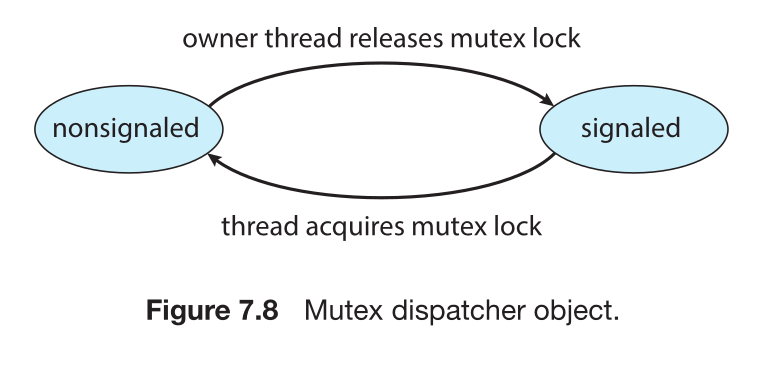


**State Transition Example - Mutex Lock (Figure 7.8):**
1.  **Initial State:** Mutex is **Signaled** (free, available).
2.  **Thread Acquires Lock:** When a thread successfully acquires the mutex, its state changes to **Nonsignaled**.
3.  **Thread Releases Lock:** When the owning thread releases the mutex, its state returns to **Signaled**.

##### **Interaction Between Object State and Thread State**
This model directly links the dispatcher object's state to the thread's scheduling state:
1.  A thread that executes a `wait()` on a **nonsignaled** object has its state changed from **READY** to **WAITING**.
2.  The thread is then placed in a **waiting queue** specifically for that object.
3.  When the object's state transitions to **signaled**, the Windows kernel checks its wait queue.
4.  **One or more threads** are moved from the **WAITING** state to the **READY** state and can resume execution.

**How Many Threads Wake Up? It depends on the object type:**
*   **Mutex:** **Only one thread** is woken up (because only one can own it). This ensures mutual exclusion.
*   **Event:** **All waiting threads** are typically woken up. This is useful for broadcast notifications (like a condition variable's `signal_all()`).

#### **Efficiency Feature: Critical-Section Objects**
Windows provides a specialized, lightweight mutual exclusion primitive for user-mode programming: the **critical-section object**.
*   **What it is:** A **user-mode mutex**. It performs acquisition and release **without entering the kernel** when there is **no contention** (i.e., the lock is free). This is very fast.
*   **On Multiprocessor Systems:** It uses an **adaptive** strategy:
    1.  **First, it spins.** The acquiring thread uses a **spinlock** for a short, predetermined duration, hoping the owning thread on another CPU will release it soon.
    2.  **If spinning fails,** it allocates a real **kernel mutex** dispatcher object and yields the CPU, blocking the thread properly.
*   **Why it's efficient:** The kernel object (with its associated overhead) is **allocated only when needed** (during contention). Since most locks are uncontended most of the time, this provides a massive performance win.

**Summary:** Windows provides a layered approach: low-level **interrupt masking** and **spinlocks** for the kernel itself, and flexible **dispatcher objects** with a signaled/nonsignaled model for user applications, topped with an optimized **critical-section** for high-performance user-mode mutual exclusion.


### **7.2.2 Synchronization in Linux**

#### **Evolution of the Linux Kernel**
*   **Pre-2.6:** The Linux kernel was **nonpreemptive**. A process running in kernel mode could **not** be interrupted, even if a higher-priority process became ready.
*   **Version 2.6 and later:** The Linux kernel became **fully preemptive**. A task executing in the kernel **can be preempted** by a higher-priority task. This change made synchronization more critical and complex within the kernel itself.

#### **Linux Kernel Synchronization Mechanisms**
Linux offers a toolkit of synchronization primitives, each suited for specific scenarios.

**1. Atomic Integers**
*   **What it is:** The simplest synchronization tool. It's an opaque data type, `atomic_t`, which ensures that all read-modify-write operations on it are **indivisible** (atomic). The hardware provides special instructions for this.
*   **How to use it:**
    ```c
    atomic_t counter; // Declare an atomic integer
    int value;
    ```
    **Example Operations & Effects:**
    *   `atomic_set(&counter, 5);` → `counter = 5`
    *   `atomic_add(10, &counter);` → `counter = counter + 10`
    *   `atomic_sub(4, &counter);` → `counter = counter - 4`
    *   `atomic_inc(&counter);` → `counter = counter + 1`
    *   `value = atomic_read(&counter);` → `value = 12` (reads value)
*   **Advantage:** **Extremely efficient.** No lock overhead. Operations are performed directly using atomic CPU instructions.
*   **Limitation:** **Use is narrow.** Only protects a single integer variable. Cannot protect complex critical sections involving multiple data items.

**2. Mutex Locks**
*   **What it is:** The standard **sleep lock** for protecting critical sections in the kernel. If the lock is unavailable, the calling task **sleeps** (blocks) and is woken up later.
*   **How to use it:**
    ```c
    mutex_lock(&lock);   // Acquire the mutex, sleep if held by another
    ... // Critical Section
    mutex_unlock(&lock); // Release the mutex, wake up a waiter
    ```
*   **Important Property:** Linux mutexes are **nonrecursive**. A thread cannot lock a mutex it already owns. A second `mutex_lock()` call on the same mutex by the same thread will **deadlock** the thread.

**3. Spinlocks**
*   **What it is:** The fundamental **busy-wait** lock for **Symmetric Multi-Processor (SMP)** systems. Designed to be held for **very short durations** (e.g., updating a list pointer).
*   **How to use it:**
    ```c
    spin_lock(&spinlock);   // Acquire the spinlock, spin if held
    ... // Very short critical section
    spin_unlock(&spinlock); // Release the spinlock
    ```
*   **Important Property:** Also **nonrecursive**.

#### **Key Linux Strategy: Unifying SMP and Single-Processor Systems**
Linux cleverly abstracts the difference between single-CPU and multi-CPU systems for locking.

*   **On Multiple-Processor (SMP) Machines:**
    *   **Use spinlocks directly.** Each processor spins on its own CPU cache while waiting.

*   **On Single-Processor (Uniprocessor) Machines:**
    *   **Spinlocks are meaningless and wasteful** (no other CPU to release the lock). Instead, Linux replaces them with **disabling/enabling kernel preemption**.
    *   **Mapping:**
        *   `spin_lock()` → `preempt_disable()` (Prevent the kernel task from being preempted)
        *   `spin_unlock()` → `preempt_enable()` (Allow preemption again)
    *   **Why this works:** On a single CPU, if kernel preemption is disabled, the current thread cannot be interrupted. This guarantees exclusive access, achieving the same effect as a spinlock but without busy-waiting.



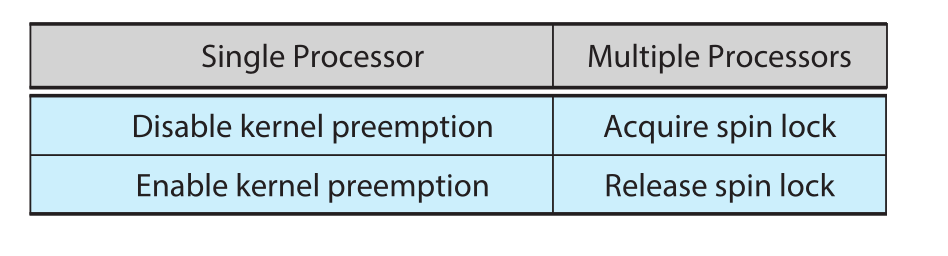


#### **The `preempt_count` Mechanism: Tracking Lock Holders**
To safely manage preemption, each task has a `thread-info` structure with a `preempt_count` field.

*   **Purpose:** This counter indicates **how many locks the task currently holds**.
*   **Rules:**
    1.  When a lock (spinlock, mutex, etc.) is acquired, `preempt_count` is **incremented**.
    2.  When the lock is released, `preempt_count` is **decremented**.
    3.  **The kernel is safe to preempt only if `preempt_count == 0`** for the currently running task. If `preempt_count > 0`, the task holds a lock, and preempting it could lead to deadlock (another task might spin forever waiting for the lock held by the preempted task).

This system ensures that a task holding a lock is **not preempted**, respecting the policy mentioned for Windows spinlocks and maintaining efficiency.

#### **Guideline: Choosing the Right Lock**
*   **Short Duration Hold (a few instructions):** Use **spinlocks** (SMP) or **preemption control** (UP).
*   **Longer Duration Hold (I/O, complex operations):** Use **semaphores** or **mutex locks** (which put the waiting task to sleep).
*   **Reader-Writer Variants:** Both spinlocks and semaphores have **reader-writer versions** (`rwlock_t`, `rw_semaphore`) for scenarios with many readers and few writers.

**Summary:** Linux provides a hierarchy from lightweight **atomic integers**, to short-hold **spinlocks** (abstracted for UP systems), to sleep-based **mutexes/semaphores**. The `preempt_count` mechanism elegantly enforces the non-preemption rule for lock holders across all these primitives.

## **7.3 POSIX Synchronization**
The previous section covered tools for **kernel developers**. **POSIX (Portable Operating System Interface)** synchronization, however, is a **user-level API** available to **application programmers**. It is a standard interface, not tied to any specific OS kernel (though it's implemented using that OS's underlying tools).

This section covers three primitives in the **Pthreads (POSIX Threads)** and POSIX API:
1.  **Mutex Locks**
2.  **Semaphores**
3.  **Condition Variables**

These are the primary tools for thread creation and synchronization on UNIX, Linux, macOS, and many other systems.


### **7.3.1 POSIX Mutex Locks**
The **mutex lock** is the most basic synchronization tool in Pthreads. It's used to protect **critical sections**—a thread **acquires** the lock before entering, and **releases** it upon leaving.

#### **Data Type and Initialization**
The `pthread_mutex_t` data type represents a mutex lock.

**Creating/Initializing a Mutex:**
```c
#include <pthread.h>

pthread_mutex_t mutex; // Declare a mutex variable

/* Create and initialize the mutex lock with default attributes */
pthread_mutex_init(&mutex, NULL);
```
*   **First Parameter (`&mutex`):** A pointer to the `pthread_mutex_t` variable.
*   **Second Parameter (`NULL`):** Specifies **attributes** for the mutex (like type: normal, recursive, error-checking). Passing `NULL` uses the **default attributes** (typically a non-recursive, fast mutex).

#### **Acquiring and Releasing the Lock**
The core operations are `pthread_mutex_lock()` and `pthread_mutex_unlock()`.

**Basic Usage Pattern:**
```c
/* Acquire the mutex lock (block if unavailable) */
pthread_mutex_lock(&mutex);

/* BEGIN CRITICAL SECTION */
... // Access shared data here
/* END CRITICAL SECTION */

/* Release the mutex lock */
pthread_mutex_unlock(&mutex);
```

**Behavior:**
*   `pthread_mutex_lock(&mutex)`: The calling thread attempts to acquire the mutex.
    *   If the mutex is **available**, the function returns immediately, and the thread now owns the lock.
    *   If the mutex is **unavailable** (held by another thread), the calling thread **blocks** (is put to sleep) until the lock's owner releases it.
*   `pthread_mutex_unlock(&mutex)`: The owning thread releases the mutex. If other threads are blocked waiting for it, **one** of them is awakened and becomes the new owner.

#### **Error Handling**
**All Pthreads mutex functions return an integer value.**
*   **Return value `0`:** indicates **success**.
*   **Return value `> 0` (a nonzero error code):** indicates **failure**. The value indicates the specific error (e.g., `EINVAL` for invalid mutex, `EDEADLK` for potential deadlock with error-checking mutexes).

**Good practice** is to check these return values in production code. Example:
```c
int ret;
ret = pthread_mutex_lock(&mutex);
if (ret != 0) {
    // Handle error (e.g., fprintf(stderr, "Mutex lock failed: %s\n", strerror(ret));
}
```

#### **Important Characteristics (Implied)**
*   **Non-Recursive by Default:** With default attributes (`NULL`), a thread attempting to lock a mutex it already owns will **deadlock itself**.
*   **Ownership:** Only the thread that acquired (`lock`) the mutex can legally release (`unlock`) it.
*   **Sleep/Wakeup:** Waiting threads are put to sleep, not spin. This is efficient for user-level locks that may be held for longer periods.

**Summary:** POSIX mutex locks provide a standardized, blocking mutual-exclusion mechanism for user-level threads. The pattern is: `init()` once, `lock()`/`unlock()` around critical sections, check return values for errors.


### **7.3.2 POSIX Semaphores**

#### **Introduction**
While mutex locks are part of the core POSIX (Pthreads) standard, **semaphores** are provided by the **POSIX SEM extension**. This means they are widely available but technically optional. POSIX specifies **two types** of semaphores:
1.  **Named Semaphores**
2.  **Unnamed Semaphores**

They function identically in terms of `wait`/`signal` operations but differ in **how they are created, identified, and shared**. Both are supported in Linux (kernel 2.6+) and macOS.


#### **7.3.2.1 POSIX Named Semaphores**

##### **Creation and Opening with `sem_open()`**
Named semaphores are identified by a **name string** (like a filename). They are primarily used for **synchronization between unrelated processes** (not just threads of the same process).

```c
#include <semaphore.h>
sem_t *sem;

/* Create the semaphore and initialize it to 1 */
sem = sem_open("/SEM", O_CREAT, 0666, 1);
```

**Function Parameters Explained:**
1.  **`"/SEM"`**: The **name** of the semaphore. It must begin with a forward slash `/`. This name is used system-wide.
2.  **`O_CREAT`**: A flag indicating the semaphore should be **created if it doesn't already exist**. If it exists, `sem_open()` just opens it.
3.  **`0666`**: The **permissions** for the semaphore (like file permissions). `0666` means read and write for owner, group, and others.
4.  **`1`**: The **initial value** of the semaphore.

**Return Value:** `sem_open()` returns a **pointer to a semaphore** (`sem_t *`) on success, or `SEM_FAILED` on error.

##### **Key Advantage: Inter-Process Communication (IPC)**
Named semaphores have **global visibility** in the system (via the name). Any unrelated process can synchronize with another by simply calling `sem_open()` with the **same semaphore name**. The OS provides the same underlying semaphore object. This makes them ideal for coordinating separate programs.

##### **Operations: `sem_wait()` and `sem_post()`**
POSIX uses different names for the classic semaphore operations:
*   **`sem_wait(sem)`**: Equivalent to `wait()` or `P()`. **Decrements** the semaphore. If the value becomes negative, the calling thread/process **blocks**.
*   **`sem_post(sem)`**: Equivalent to `signal()` or `V()`. **Increments** the semaphore. If other threads/processes are blocked waiting, **one** is awakened.

**Usage Pattern to Protect a Critical Section:**
```c
/* Acquire the semaphore (decrement) */
sem_wait(sem);

/* BEGIN CRITICAL SECTION */
... // Access shared resource (could be in shared memory)
/* END CRITICAL SECTION */

/* Release the semaphore (increment) */
sem_post(sem);
```

##### **Important Considerations**
1.  **System Persistence:** Named semaphores have **kernel persistence**. They continue to exist until explicitly removed with `sem_unlink()` or the system reboots. This is why the name often resembles a file path—it's managed by the OS.
2.  **Cleanup:** A process should use `sem_close(sem)` when done using the semaphore to release local resources. The `sem_unlink("/SEM")` system call removes the semaphore name and object from the system when no processes have it open.
3.  **Initial Value:** The initial value determines the semaphore's type:
    *   **`1`** → Binary semaphore (often used as a mutex).
    *   **`N`** → Counting semaphore (allows N concurrent accesses).

**Summary:** POSIX named semaphores are a powerful, system-wide synchronization primitive, ideal for coordinating between separate processes using a simple string name. Their API mirrors the classic semaphore operations with `sem_wait()` and `sem_post()`.